In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Functions

In [ ]:
def center_data(X):
    row_means = np.mean(X, axis=1, keepdims=True)
    Y = X - row_means
    return Y

In [ ]:
def compute_covariance_matrix(Y):
    covariance_matrix = np.dot(Y.T, Y)
    return covariance_matrix

In [65]:
def compute_eigenvalues_and_eigenvectors(covariance_matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    return eigenvalues, eigenvectors

In [66]:
def select_top_eigenvectors(eigenvalues, eigenvectors, K):
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_indices = sorted_indices[:K-1]
    top_eigenvalues = eigenvalues[top_indices]
    top_eigenvectors = eigenvectors[:, top_indices]
    return top_eigenvalues, top_eigenvectors

In [67]:
def compute_bounds(Y, top_eigenvalues):
    y_squared_sum = np.sum(np.sum(Y ** 2, axis=0))
    eigenvalues_sum = np.sum(top_eigenvalues)
    lower_bound = y_squared_sum - eigenvalues_sum 
    upper_bound = y_squared_sum
    return lower_bound, upper_bound

In [68]:
def compute_projection_matrix(top_eigenvectors):
    P = np.zeros((top_eigenvectors.shape[0], top_eigenvectors.shape[0]))
    for i in range(top_eigenvectors.shape[1]):
        v = top_eigenvectors[:, i].reshape(-1, 1)
        P += np.dot(v, v.T)
    return P

In [69]:
def compute_connectivity_matrix(P, alpha=0.5):
    row_sums = np.sqrt(np.diag(P))
    normalization = np.outer(row_sums, row_sums)
    R = P / normalization

    C = np.where(R >= alpha, P, 0)
    return C

In [70]:
def compute_laplacian(C):
    D = np.diag(np.sum(C, axis=1))
    L = D - C
    return L

In [71]:
def compute_fiedler_vector(L):
    _, eigenvectors = np.linalg.eigh(L)
    fiedler_vector = eigenvectors[:, 1]
    return fiedler_vector

In [72]:
def compute_permutation(fiedler_vector):
    pi = np.argsort(fiedler_vector)
    return pi

In [ ]:
def compute_cluster_crossing(C, pi, K):
    n = len(C)
    m = int(np.ceil(n/K))
    rho = np.zeros(n)
    for i in range(n):
        t = min(i+1, n - i, m)
        rho[i] = (m / t) * sum(C[pi[i - j], pi[i + j]] for j in range(1, t))
    return rho

In [ ]:
def smooth_cluster_crossing(C, pi, rho, K):
    n = len(C)
    m = int(np.ceil(n/K))
    smoothed_rho = np.zeros_like(rho)

    for i in range(1, n-1):
        t = min(i + 1, n - i, m)

        if i < n - 1:
            rho_plus_half = 0
            t_counter = 0
            for j in range(1, t):
                if i + j + 1 < n:
                    rho_plus_half += C[pi[i - j], pi[i + j + 1]]
                    t_counter += 1
            rho_plus_half *= m/t_counter if t_counter > 0 else 0
        else:
            rho_plus_half = 0

        if i > 0:
            rho_minus_half = 0
            t_counter = 0
            for j in range(1, t):
                if i + j - 1 < n:
                    rho_minus_half += C[pi[i - j], pi[i + j - 1]]
                    t_counter += 1
            rho_minus_half *= m/t_counter if t_counter > 0 else 0
        else:
            rho_minus_half = 0

        smoothed_rho[i] = (rho_plus_half / 4) + (rho[i] / 2) + (rho_minus_half / 4)

    return smoothed_rho

In [75]:
def find_valleys(C, pi, rho, K):
    n = len(rho)
    neighborhood = 1  # Start with 1 neighbor on each side
    current_valleys = []

    while neighborhood <= n // 2:  # Avoid exceeding half the array length
        # Find valleys for the current neighborhood size
        candidate_valleys = []
        for i in range(neighborhood, n - neighborhood):
            if all(rho[i] <= rho[i - j] for j in range(1, neighborhood + 1)) and \
               all(rho[i] <= rho[i + j] for j in range(1, neighborhood + 1)):
                candidate_valleys.append(i)

        # Resolve ties for valleys in the same neighborhood
        unique_valleys = []
        i = 0
        while i < len(candidate_valleys):
            start_idx = i
            while i + 1 < len(candidate_valleys) and candidate_valleys[i + 1] - candidate_valleys[i] <= neighborhood:
                i += 1

            # If there are multiple valleys in the same neighborhood, resolve ties
            if i > start_idx:
                tied_valleys = candidate_valleys[start_idx:i + 1]
                # Find the most distinct valley based on neighbor differences
                best_valley = min(tied_valleys, key=lambda x: min(
                    C[pi[x], pi[x - 1]] if x - 1 >= 0 else float('inf'),
                    C[pi[x], pi[x + 1]] if x + 1 < n else float('inf')
                ))
                unique_valleys.append(best_valley)
            else:
                unique_valleys.append(candidate_valleys[i])

            i += 1

        candidate_valleys = unique_valleys

        # Check if the number of valleys matches K-1
        if len(candidate_valleys) == K - 1:
            return candidate_valleys  # Found the desired valleys

        # If we fall below K-1 valleys, revert to the previous step
        if len(candidate_valleys) < K - 1:
            # Select the K-1 valleys with the lowest values from the last valid neighborhood
            if len(current_valleys) > K - 1:
                current_valleys = sorted(current_valleys, key=lambda x: rho[x])[:K - 1]
            return current_valleys

        # Otherwise, update and expand the neighborhood
        current_valleys = candidate_valleys
        neighborhood += 1

    # Final fallback: If no valid K-1 valleys are found, use the closest approximation
    if len(current_valleys) > K - 1:
        current_valleys = sorted(current_valleys, key=lambda x: rho[x])[:K - 1]

    return current_valleys

In [ ]:
def recursive_clustering(C, K):

    # Step 1: Compute Laplacian and Fiedler vector
    L = compute_laplacian(C)
    fiedler_vector = compute_fiedler_vector(L)

    # Step 2: Permute connectivity matrix based on Fiedler vector ordering
    pi = compute_permutation(fiedler_vector)

    # Step 3: Compute crossing curve
    rho = compute_cluster_crossing(C, pi, K)
    smoothed_rho = smooth_cluster_crossing(C, pi, rho, K)

    # Step 4: Locate valley points in the crossing curve
    valleys = find_valleys(C, pi, smoothed_rho, K)
    print(valleys)

    # Step 5: Initial cluster assignment based on valleys
    clusters = []
    start = 0

    for valley in valleys:
        # Assign the range before the valley to a cluster
        cluster_range = pi[start:valley]
        clusters.append(cluster_range)

        # Compare valley point's connectivity to left and right neighbors
        if valley - 1 >= 0:
            left_connectivity = C[pi[valley], pi[valley - 1]]
        else:
            left_connectivity = float('-inf')  # No left neighbor for the first valley

        if valley + 1 < len(C):
            right_connectivity = C[pi[valley], pi[valley + 1]]
        else:
            right_connectivity = float('-inf')  # No right neighbor for the last valley

        # Assign valley to the cluster with the higher connectivity
        if left_connectivity >= right_connectivity:
            clusters[-1] = np.append(clusters[-1], pi[valley])
            start = valley + 1
        else:
            start = valley
            continue  # Skip this valley as it belongs to the next cluster

    # Add the final range after the last valley
    clusters.append(pi[start:])

    return clusters, smoothed_rho

In [77]:
def run_clustering(X, K):
    n = X.shape[1]

    m = int(np.ceil(n / K))
    
    Y = center_data(X)

    covariance_matrix = compute_covariance_matrix(Y)

    eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(covariance_matrix)

    top_eigenvalues, top_eigenvectors = select_top_eigenvectors(eigenvalues, eigenvectors, K)

    lower_bound, upper_bound = compute_bounds(Y, top_eigenvalues)

    P = compute_projection_matrix(top_eigenvectors)

    C = compute_connectivity_matrix(P)

    clusters = recursive_clustering(C, K)

    return clusters

# Test

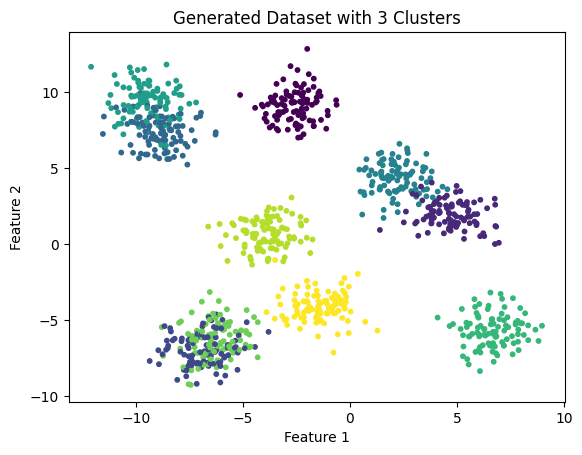

In [78]:
n_samples = 1000
n_features = 2
n_clusters = 10

# Generate dataset
X, y = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, cluster_std=1.0, random_state=42)

# Transpose X to match your format (features as rows, observations as columns)
X = X.T

plt.scatter(X[0], X[1], c=y, cmap='viridis', s=10)
plt.title("Generated Dataset with 3 Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


In [79]:
K = 10

n = X.shape[1]

m = int(np.ceil(n / K))

Y = center_data(X)

covariance_matrix = compute_covariance_matrix(Y)

eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(covariance_matrix)

top_eigenvalues, top_eigenvectors = select_top_eigenvectors(eigenvalues, eigenvectors, K)

lower_bound, upper_bound = compute_bounds(Y, top_eigenvalues)

P = compute_projection_matrix(top_eigenvectors)

C = compute_connectivity_matrix(P)

In [80]:
clusters, smoothed_rho = recursive_clustering(C, K)
for c in clusters:
    print(sorted(c))

[201, 268, 315, 355, 392, 534, 578, 639, 724]
[np.int64(31), np.int64(35), np.int64(36), np.int64(40), np.int64(49), np.int64(57), np.int64(61), np.int64(64), np.int64(69), np.int64(71), np.int64(75), np.int64(81), np.int64(83), np.int64(87), np.int64(88), np.int64(91), np.int64(94), np.int64(95), np.int64(96), np.int64(99), np.int64(100), np.int64(103), np.int64(104), np.int64(107), np.int64(109), np.int64(110), np.int64(111), np.int64(113), np.int64(126), np.int64(127), np.int64(128), np.int64(131), np.int64(135), np.int64(136), np.int64(138), np.int64(139), np.int64(146), np.int64(150), np.int64(152), np.int64(153), np.int64(160), np.int64(176), np.int64(182), np.int64(185), np.int64(186), np.int64(199), np.int64(211), np.int64(213), np.int64(214), np.int64(216), np.int64(224), np.int64(226), np.int64(227), np.int64(241), np.int64(244), np.int64(250), np.int64(252), np.int64(256), np.int64(260), np.int64(268), np.int64(270), np.int64(278), np.int64(281), np.int64(287), np.int64(295)

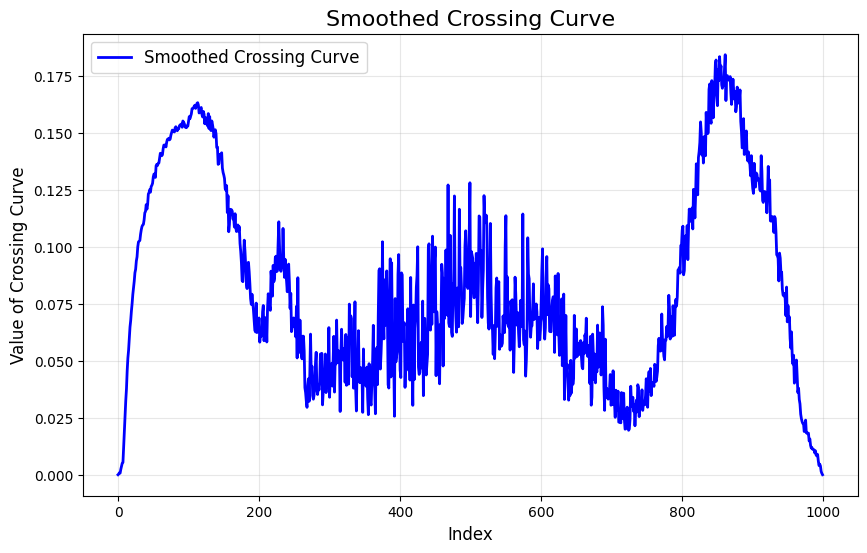

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(smoothed_rho)), smoothed_rho, label="Smoothed Crossing Curve", color="blue", linewidth=2)

plt.title("Smoothed Crossing Curve", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Value of Crossing Curve", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

plt.show()

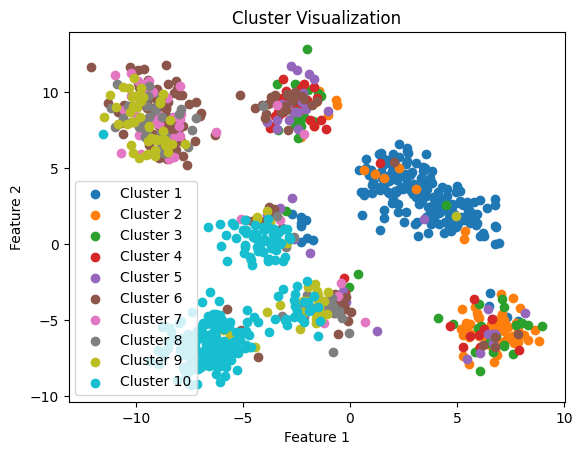

In [82]:
def plot_clusters(X, clusters):
    num_clusters = len(clusters)
    colors = plt.get_cmap("tab10", num_clusters)

    for cluster_id, cluster_indices in enumerate(clusters):
        cluster_points = X[:, cluster_indices]
        plt.scatter(cluster_points[0], cluster_points[1], label=f"Cluster {cluster_id + 1}", color=colors(cluster_id))

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Cluster Visualization")
    plt.legend()
    plt.show()

plot_clusters(X, clusters)